# Predict House Prices - ML Pipeline

## Objectives

*   Find and evaluate a regression model to predict house prices


## Inputs

* outputs/datasets/collection/HousePricesRecords.csv
* Instructions on variable selection and data transformation/cleaning from Data Cleaning and Feature Engineering notebooks

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house price
* Feature Importance Plot

## Conclusion

* Conclusion

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing'

---

# Load Data

In [4]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import warnings
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from itertools import combinations
from functools import reduce
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer




/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv"))
  
print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,No,706.0,GLQ,150.0,0.0,548.0,RFn,...,65.0,196.0,61.0,5,7,856.0,0.0,2003,2003,208500
1,1262.0,0.0,3.0,Gd,978.0,ALQ,284.0,NaN,460.0,RFn,...,80.0,0.0,0.0,8,6,1262.0,NaN,1976,1976,181500
2,920.0,866.0,3.0,Mn,486.0,GLQ,434.0,0.0,608.0,RFn,...,68.0,162.0,42.0,5,7,920.0,NaN,2001,2002,223500


---

Vars for preprocessing data

In [6]:
# Categorical mapping dictionary
cat_map = {'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0},
 'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0},
  'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0},
   'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}}

# Variables with missing data
vars_with_missing_data = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'GarageFinish',
                          'GarageYrBlt', 'LotFrontage', 'MasVnrArea']     

### Custom classes for pipeline

Based on conclusions from Data Cleaning and Feature Engineering 

In [7]:
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop):
        self.features_to_drop = features_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy.drop(self.features_to_drop, axis=1, inplace=True)
        return X_copy

In [8]:
class CategoricalMapper(BaseEstimator, TransformerMixin):
    def __init__(self, cat_map):
        self.cat_map = cat_map

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column, mapping in self.cat_map.items():
            X_transformed[column] = X_transformed[column].map(mapping)
        return X_transformed

In [9]:
class MissingDataImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)

    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = pd.DataFrame(self.imputer.transform(X_copy), columns=X_copy.columns)
        return X_copy

In [10]:
import warnings
from feature_engine.selection import SmartCorrelatedSelection

class CustomSmartCorrelatedSelection(SmartCorrelatedSelection):
    def __init__(self, method='spearman', threshold=0.6, selection_method='variance'):
        super().__init__(variables=[], method=method, threshold=threshold, selection_method=selection_method)
        self.correlated_feature_sets_ = None

    def fit(self, X, y=None):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            return super().fit(X, y)

In [11]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = np.log(X_copy[self.column])
        return X_copy

-----


In [12]:
print(df.columns)

Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
       'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd',
       'SalePrice'],
      dtype='object')


## Define pipeline

In [13]:
def PipelineOptimization(model):
    pipeline = Pipeline([
        ("drop_features", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("categorical_mapper", CategoricalMapper(cat_map)),
        ('missing_data_imputer', MissingDataImputer(strategy='median')),
        ('corr_sel', CustomSmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])
    return pipeline


Custom Class for hyperparameter optimisation

In [14]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [15]:
from sklearn.model_selection import train_test_split

# Split Train Test Set
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [16]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [17]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.672712,0.800495,0.867736,0.073092
2,RandomForestRegressor,0.632989,0.791839,0.85964,0.083685
0,LinearRegression,0.701462,0.77925,0.824712,0.041363
5,GradientBoostingRegressor,0.639305,0.763939,0.850056,0.083875
6,XGBRegressor,0.637822,0.738218,0.821103,0.070041
4,AdaBoostRegressor,0.621051,0.721318,0.794948,0.063986
1,DecisionTreeRegressor,0.495511,0.623105,0.674645,0.067497


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [19]:
# Extensive search on the most suitable model to find the best hyperparameter configuration
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "LinearRegression": LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                           'model__max_depth': [None, 3, 15],
                           'model__min_samples_split': [2, 50],
                           'model__min_samples_leaf': [1,50],
    },
    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
    },
    "LinearRegression":{},
    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                 'model__learning_rate':[0.1, 0.01, 0.001],
                                 'model__max_depth': [3,15, None],
                                 'model__min_samples_split': [2,50],
                                 'model__min_samples_leaf': [1,50],
                                 'model__max_leaf_nodes': [None,50],
    }
}

Extensive GridSearch CV

In [20]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Check results

In [21]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(50)

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__max_leaf_nodes,model__learning_rate
132,GradientBoostingRegressor,0.76362,0.812701,0.851956,0.032381,3,50,50,140,50,0.1
129,GradientBoostingRegressor,0.76362,0.812701,0.851956,0.032381,3,50,2,140,50,0.1
120,GradientBoostingRegressor,0.76362,0.812701,0.851956,0.032381,3,50,50,140,None,0.1
117,GradientBoostingRegressor,0.76362,0.812701,0.851956,0.032381,3,50,2,140,None,0.1
130,GradientBoostingRegressor,0.762197,0.812534,0.850881,0.032696,3,50,50,100,50,0.1
127,GradientBoostingRegressor,0.762197,0.812534,0.850881,0.032696,3,50,2,100,50,0.1
115,GradientBoostingRegressor,0.762197,0.812534,0.850881,0.032696,3,50,2,100,None,0.1
118,GradientBoostingRegressor,0.762197,0.812534,0.850881,0.032696,3,50,50,100,None,0.1
141,GradientBoostingRegressor,0.758107,0.811251,0.855001,0.034865,15,50,2,140,None,0.1
144,GradientBoostingRegressor,0.758107,0.811251,0.855001,0.034865,15,50,50,140,None,0.1


---

Evaluate the four algorithms

### 1. GradientBoostingRegressor

Check the best model

In [22]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [23]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

Define the best regressor, based on search

In [24]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('categorical_mapper',
                 CategoricalMapper(cat_map={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                             'Mn': 2, 'No': 1,
                                                             'None': 0},
                                            'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                             'GLQ': 6, 'LwQ': 2,
                                                             'None': 0,
                                                             'Rec': 3,
                                                             'Unf': 1},
                                            'GarageFinish': {'Fin': 3,
                                                             'None': 0,
                                              

## Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


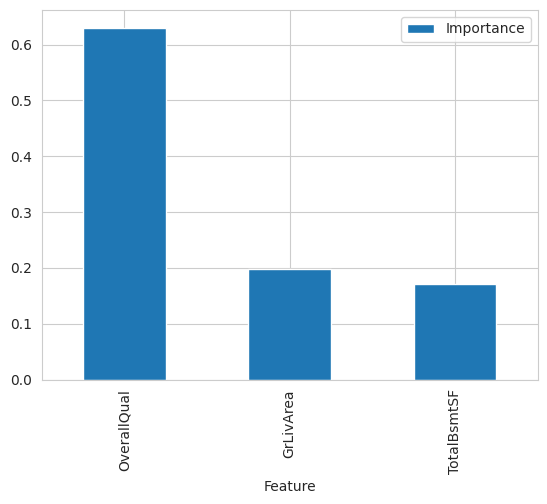

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 4
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [26]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.834
Mean Absolute Error: 21359.496
Mean Squared Error: 1024460750.793
Root Mean Squared Error: 32007.198


* Test Set
R2 Score: 0.761
Mean Absolute Error: 24327.455
Mean Squared Error: 1648795357.104
Root Mean Squared Error: 40605.361




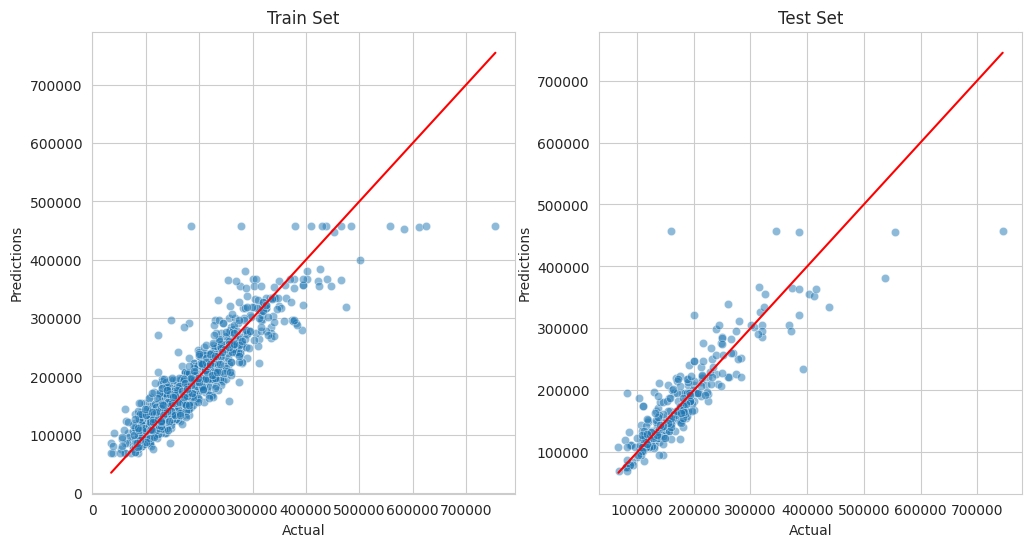

In [27]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---



### 2. ExtraTreesRegressor

In [28]:
best_model = grid_search_summary.iloc[28,0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [29]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

Define the best regressor, based on search

In [30]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('categorical_mapper',
                 CategoricalMapper(cat_map={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                             'Mn': 2, 'No': 1,
                                                             'None': 0},
                                            'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                             'GLQ': 6, 'LwQ': 2,
                                                             'None': 0,
                                                             'Rec': 3,
                                                             'Unf': 1},
                                            'GarageFinish': {'Fin': 3,
                                                             'None': 0,
                                              

## Assess feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageArea']


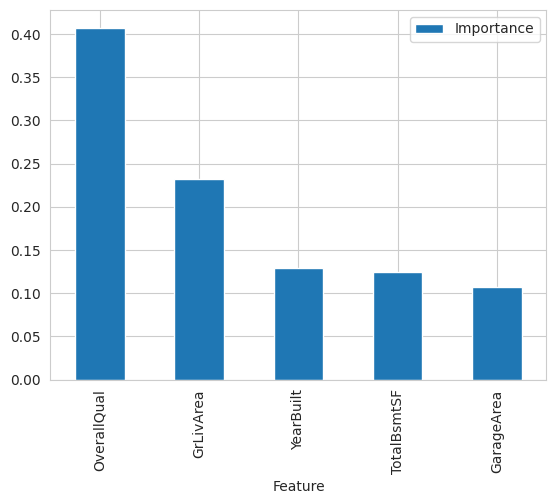

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 4
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [32]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.998
Mean Absolute Error: 2031.201
Mean Squared Error: 10006565.89
Root Mean Squared Error: 3163.316


* Test Set
R2 Score: 0.864
Mean Absolute Error: 19491.898
Mean Squared Error: 939029175.811
Root Mean Squared Error: 30643.583




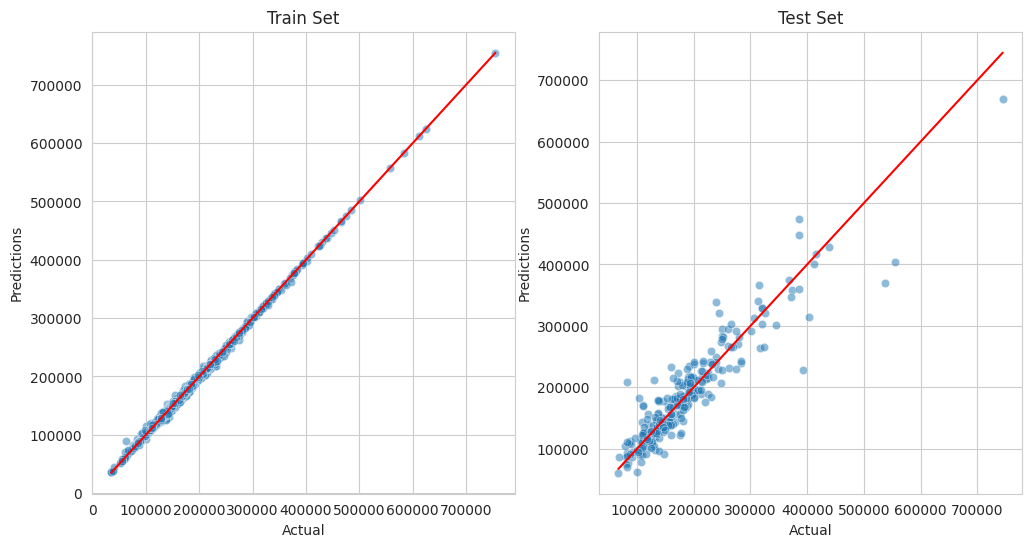

In [33]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---



### 4. LinearRegression

In [34]:
best_model = grid_search_summary.iloc[47,0]
best_model

'RandomForestRegressor'

Parameters for best model

In [35]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

Define the best regressor, based on search

In [36]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('categorical_mapper',
                 CategoricalMapper(cat_map={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                             'Mn': 2, 'No': 1,
                                                             'None': 0},
                                            'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                             'GLQ': 6, 'LwQ': 2,
                                                             'None': 0,
                                                             'Rec': 3,
                                                             'Unf': 1},
                                            'GarageFinish': {'Fin': 3,
                                                             'None': 0,
                                              

## Assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea']


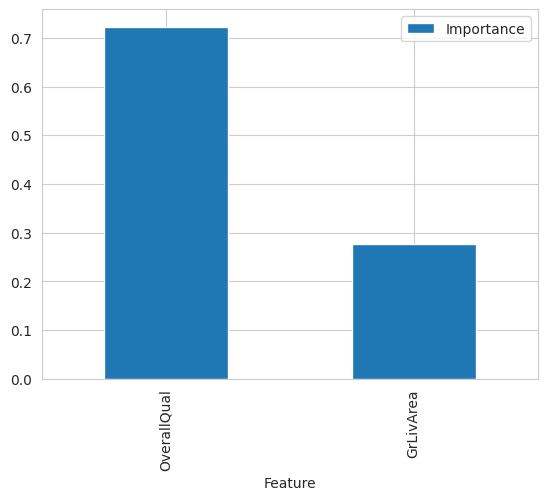

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 4
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [38]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.864
Mean Absolute Error: 21851.806
Mean Squared Error: 837623498.196
Root Mean Squared Error: 28941.726


* Test Set
R2 Score: 0.796
Mean Absolute Error: 24320.864
Mean Squared Error: 1410871090.105
Root Mean Squared Error: 37561.564




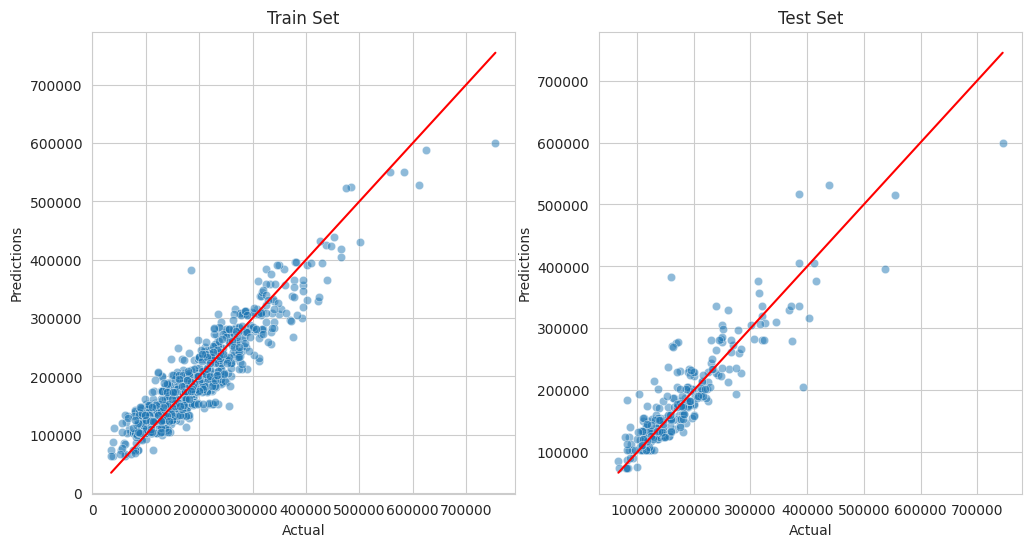

In [39]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---



### 3. RandomForestRegressor

In [40]:
best_model = grid_search_summary.iloc[47,0]
best_model

'RandomForestRegressor'

Parameters for best model

In [41]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

Define the best regressor, based on search

In [42]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('categorical_mapper',
                 CategoricalMapper(cat_map={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                             'Mn': 2, 'No': 1,
                                                             'None': 0},
                                            'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                             'GLQ': 6, 'LwQ': 2,
                                                             'None': 0,
                                                             'Rec': 3,
                                                             'Unf': 1},
                                            'GarageFinish': {'Fin': 3,
                                                             'None': 0,
                                              

## Assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea']


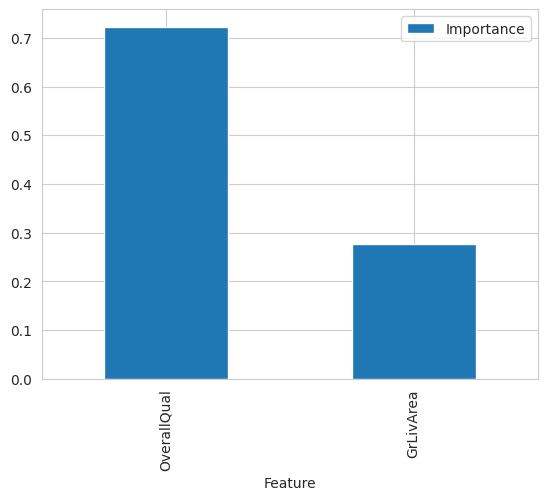

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 4
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [44]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.864
Mean Absolute Error: 21851.806
Mean Squared Error: 837623498.196
Root Mean Squared Error: 28941.726


* Test Set
R2 Score: 0.796
Mean Absolute Error: 24320.864
Mean Squared Error: 1410871090.105
Root Mean Squared Error: 37561.564




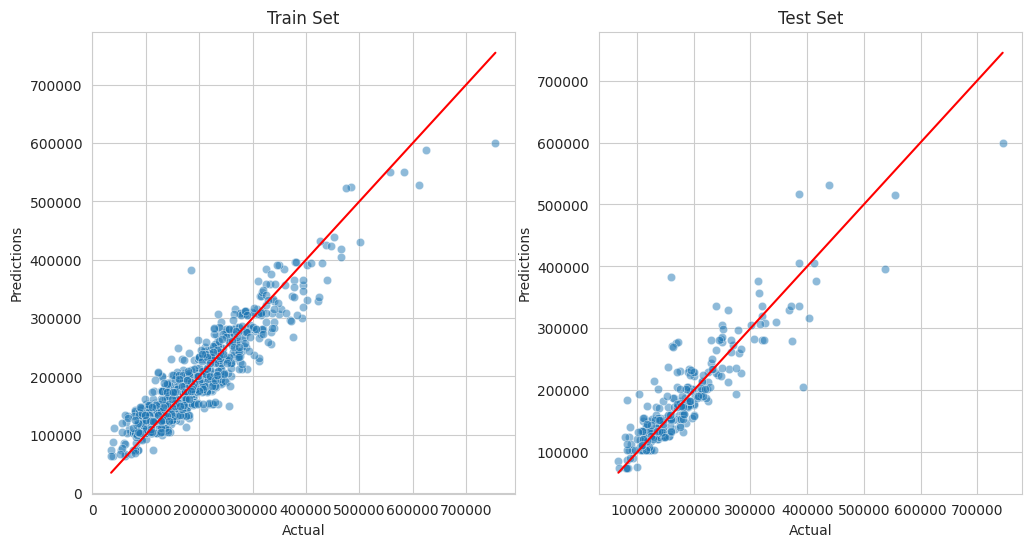

/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

In [45]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Which pipeline to choose?

We fitted pipelines with four different algorithms:

    * ExtraTreesRegressor
    * RandomForestRegressor
    * LinearRegression
    * GradientBoostingRegressor

RandomForestRegressor  performs the best, with a mean R2 score of 0.791839 

# Refit pipeline with best features

## Rewrite Pipeline

Since the RandomForestRegressor only used two features, 'OverallQual' and 'GrLivArea' for training, we can rewrite the pipeline to use only these variables. We comment out the unneeded pipeline steps:

In [ ]:
def PipelineOptimization(model):
    pipeline = Pipeline([
        #("drop_features", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        #("categorical_mapper", CategoricalMapper(cat_map)),
        #('missing_data_imputer', MissingDataImputer(strategy='median')),
        #('corr_sel', CustomSmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        #("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])
    return pipeline

## Split Train Test Set, only with best features

Subset Best Features

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor":{'model__n_estimators': [100],
                             'model__max_depth': [None],
                             'model__min_samples_split': [2],
                             'model__min_samples_leaf': [1],
                             'model__max_leaf_nodes': [50],
    },
}

GridSearch CV

In [ ]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

## Evaluate on Train and Test Sets

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

----

# Generate files for dashboard

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/predict_house_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [ ]:
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [ ]:
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [ ]:
ML pipeline for predicting sale price

In [ ]:
best_regressor_pipeline

In [ ]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

## Feature importance plot

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

---